Dưới đây là phân tích chủ đề T3: **Trích xuất các hợp chất giống lead từ cơ sở dữ liệu ChEMBL 35** bằng cách sử dụng SQL và RDKit, phù hợp với cấu trúc dự án AIMLOps.

---

## 🧪 T3. Lead-Like Compound Extraction – Phân tích hợp chất giống lead

**Lead-like molecules** là các hợp chất nhỏ có tiềm năng trở thành thuốc (lead compounds), đặc biệt được chọn để có khả năng hấp thu, phân bố, chuyển hoá, thải trừ (ADME) tốt và độc tính thấp. Một số tiêu chí thường dùng (Lead-like Rule of 3 hoặc Teague's filters):

| Tiêu chí        | Lead-like Rule |
| --------------- | -------------- |
| MolWt           | < 350 g/mol    |
| LogP            | < 3.5          |
| HBD             | ≤ 3            |
| HBA             | ≤ 6            |
| Rotatable Bonds | ≤ 7            |

---

## 🎯 1. Mô hình phân tích – Analysis Framework

**Bước 1:** Truy xuất dữ liệu từ ChEMBL 35 thông qua `psql` → lưu `../data/T3_leadlike_data.csv`
**Bước 2:** Dùng RDKit tính toán mô tả phân tử: MolWt, LogP, HBD, HBA, RotBonds
**Bước 3:** Lọc theo tiêu chí lead-like
**Bước 4:** Lưu tập dữ liệu lọc ra file `../data/T3_leadlike_filtered.csv` để dùng trong nghiên cứu tiếp theo hoặc huấn luyện mô hình.

---

## 📌 2. Hướng dẫn song ngữ

**English:**
We extract small molecules from ChEMBL 35, compute molecular descriptors using RDKit, then filter based on lead-likeness criteria such as molecular weight, logP, H-bond donors/acceptors, and rotatable bonds.

**Tiếng Việt:**
Chúng ta trích xuất các hợp chất nhỏ từ ChEMBL 35, tính toán các mô tả phân tử bằng RDKit, sau đó lọc theo tiêu chí giống lead như trọng lượng phân tử, logP, số liên kết hydro cho nhận và số liên kết xoay.

---

## 📂 3. SQL Query (Lưu ý: Lọc dữ liệu sạch, chỉ lấy 100 dòng đầu)

```sql
-- File: T3_leadlike_extract.sql
SELECT md.chembl_id, cs.canonical_smiles
FROM compound_structures cs
JOIN molecule_dictionary md ON cs.molregno = md.molregno
WHERE cs.canonical_smiles IS NOT NULL
LIMIT 100;
```

> ⚠ Tránh lỗi regex không áp dụng trên kiểu `numeric`, chỉ dùng trên text!

---

## 🧬 4. Python code to compute descriptors

```python
# File: T3_1_extract_leadlike_compounds.ipynb
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import os

# Step 1: Load CSV
base_path = '..'
file_path = os.path.join(base_path, 'data', 'T3_leadlike_extract.csv')
df = pd.read_csv(file_path)

# Step 2: Compute descriptors
def calc_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return {
            'MolWt': Descriptors.MolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'HBD': Lipinski.NumHDonors(mol),
            'HBA': Lipinski.NumHAcceptors(mol),
            'RotBonds': Descriptors.NumRotatableBonds(mol)
        }
    else:
        return None

descriptor_list = df['canonical_smiles'].apply(calc_descriptors)
desc_df = pd.DataFrame(descriptor_list.tolist())
df = pd.concat([df, desc_df], axis=1)

# Step 3: Apply lead-like filters
leadlike_df = df[
    (df['MolWt'] < 350) &
    (df['LogP'] < 3.5) &
    (df['HBD'] <= 3) &
    (df['HBA'] <= 6) &
    (df['RotBonds'] <= 7)
]

# Step 4: Save result
output_path = os.path.join(base_path, 'data', 'T3_leadlike_filtered.csv')
leadlike_df.to_csv(output_path, index=False)
leadlike_df.head()
```

---

## 📎 5. 5 ví dụ SQL và Python mẫu

### 🔹 Ví dụ 1 – Lọc theo MolWt < 350

```sql
SELECT cs.canonical_smiles
FROM compound_structures cs
JOIN molecule_dictionary md ON cs.molregno = md.molregno
WHERE cs.canonical_smiles IS NOT NULL
LIMIT 100;
```

### 🔹 Ví dụ 2 – Lọc các hợp chất có cấu trúc SMILES không rỗng

```sql
SELECT md.chembl_id, cs.canonical_smiles
FROM compound_structures cs
JOIN molecule_dictionary md ON cs.molregno = md.molregno
WHERE cs.canonical_smiles IS NOT NULL AND LENGTH(cs.canonical_smiles) > 5
LIMIT 100;
```

### 🔹 Ví dụ 3 – Python: tính MolWt

```python
df['MolWt'] = df['canonical_smiles'].apply(lambda s: Descriptors.MolWt(Chem.MolFromSmiles(s)))
```

### 🔹 Ví dụ 4 – Python: Lọc theo MolWt + LogP

```python
df_filtered = df[(df['MolWt'] < 350) & (df['LogP'] < 3.5)]
```

### 🔹 Ví dụ 5 – Python: Tính toàn bộ Lipinski filters

```python
df['HBD'] = df['canonical_smiles'].apply(lambda s: Lipinski.NumHDonors(Chem.MolFromSmiles(s)))
df['HBA'] = df['canonical_smiles'].apply(lambda s: Lipinski.NumHAcceptors(Chem.MolFromSmiles(s)))
```

---

Nếu bạn cần mình zip lại code mẫu `T3_1_*.ipynb` hoặc tạo thêm phần `T3_2_*.ipynb` để trực quan hóa kết quả bằng biểu đồ hoặc dùng cho QSAR, hãy báo nhé.


In [1]:
# File: T3_1_extract_leadlike_compounds.ipynb
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import os

# Step 1: Load CSV
base_path = '..'
file_path = os.path.join(base_path, 'data', 'T3_leadlike_extract.csv')
df = pd.read_csv(file_path)

# Step 2: Compute descriptors
def calc_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return {
            'MolWt': Descriptors.MolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'HBD': Lipinski.NumHDonors(mol),
            'HBA': Lipinski.NumHAcceptors(mol),
            'RotBonds': Descriptors.NumRotatableBonds(mol)
        }
    else:
        return None

descriptor_list = df['canonical_smiles'].apply(calc_descriptors)
desc_df = pd.DataFrame(descriptor_list.tolist())
df = pd.concat([df, desc_df], axis=1)

# Step 3: Apply lead-like filters
leadlike_df = df[
    (df['MolWt'] < 350) &
    (df['LogP'] < 3.5) &
    (df['HBD'] <= 3) &
    (df['HBA'] <= 6) &
    (df['RotBonds'] <= 7)
]

# Step 4: Save result
output_path = os.path.join(base_path, 'data', 'T3_leadlike_filtered.csv')
leadlike_df.to_csv(output_path, index=False)
leadlike_df.head()


,chembl_id,canonical_smiles,MolWt,LogP,HBD,HBA,RotBonds
0,CHEMBL6329,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl,341.754,2.11362,1,5,3
1,CHEMBL6328,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1,332.319,1.33190,1,6,3
3,CHEMBL6362,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1,307.309,1.46022,1,5,3
4,CHEMBL267864,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1,341.754,2.11362,1,5,3
5,CHEMBL6363,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1,307.309,1.46022,1,5,3


Dưới đây là phần mở rộng: **T3\_2\_Visualizing Lead-like Compound Properties.ipynb** giúp trực quan hóa các đặc trưng phân tử của các hợp chất giống lead bằng biểu đồ (histogram, scatter, pairplot).

---

## 📊 T3\_2 – Visualizing Lead-like Compounds

**🎯 Mục tiêu:** So sánh phân bố các đặc trưng (MolWt, LogP, HBD, HBA, RotBonds) giữa tập gốc và tập đã lọc theo tiêu chí lead-like.

---

### ✅ Python Visualization Code (T3\_2\_Visualize.ipynb)

```python
# File: notebook/T3_2_visualize_leadlike.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Setup
base_path = '..'
input_path_all = os.path.join(base_path, 'data', 'T3_leadlike_extract.csv')
input_path_filtered = os.path.join(base_path, 'data', 'T3_leadlike_filtered.csv')

# Load
df_all = pd.read_csv(input_path_all)
df_filtered = pd.read_csv(input_path_filtered)

# Plot settings
sns.set(style='whitegrid', font_scale=1.2)

# Histograms of descriptors
descriptors = ['MolWt', 'LogP', 'HBD', 'HBA', 'RotBonds']
for desc in descriptors:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_all[desc], color='blue', label='All', kde=True, stat='density', bins=30)
    sns.histplot(df_filtered[desc], color='green', label='Lead-like', kde=True, stat='density', bins=30)
    plt.title(f'Distribution of {desc}')
    plt.legend()
    plt.tight_layout()
    plt.show()
```

---

### 🔎 Pairplot (Optional - overview of correlations)

```python
# Optional: compare correlation structure visually
selected_cols = ['MolWt', 'LogP', 'HBD', 'HBA', 'RotBonds']
sns.pairplot(df_filtered[selected_cols])
plt.suptitle("Pairwise Relationships in Lead-like Molecules", y=1.02)
plt.show()
```

---

### 📌 Gợi ý mở rộng:

* Bạn có thể thêm biểu đồ **Boxplot** để so sánh trực tiếp giữa nhóm “tất cả hợp chất” và nhóm “giống lead”.
* Nếu nhiều dữ liệu hơn: thêm biểu đồ **Violinplot** hoặc trực quan hóa theo phân cụm (KMeans).

---

## 📁 Tên file gợi ý:

* Notebook: `notebook/T3_2_visualize_leadlike.ipynb`
* Dữ liệu đầu vào:

  * `../data/T3_leadlike_extract.csv`
  * `../data/T3_leadlike_filtered.csv`
* Hình ảnh có thể lưu vào `../images/leadlike/`

---

Bạn có muốn mình tạo thêm biểu đồ dạng interactive dùng Plotly hoặc Streamlit để trực quan hoá trên web không?
v

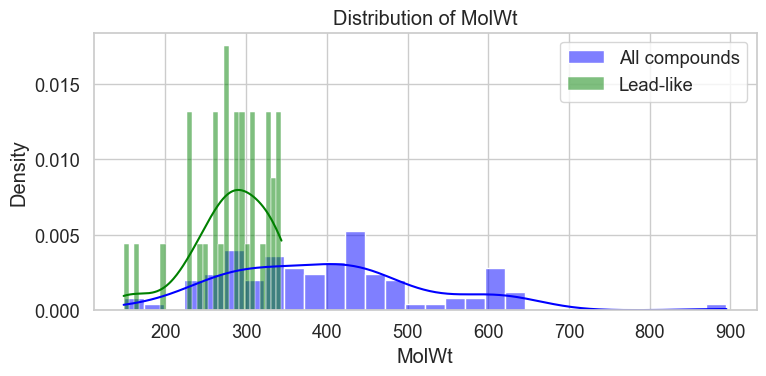

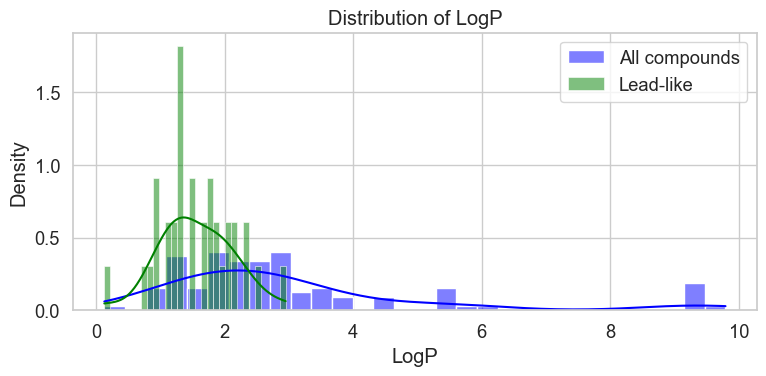

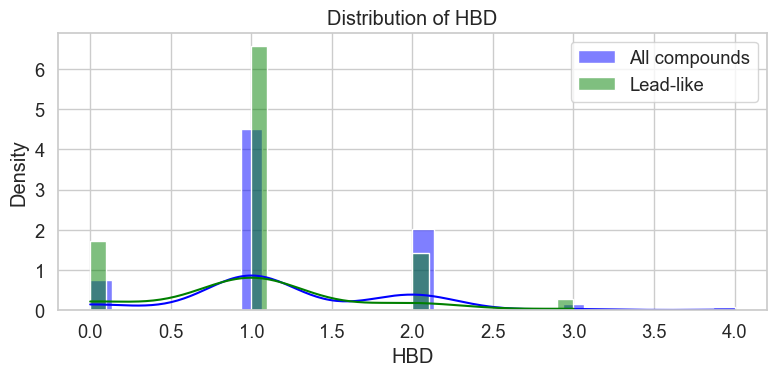

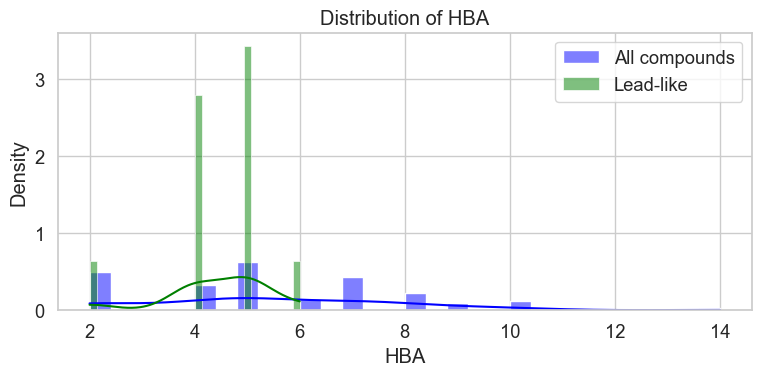

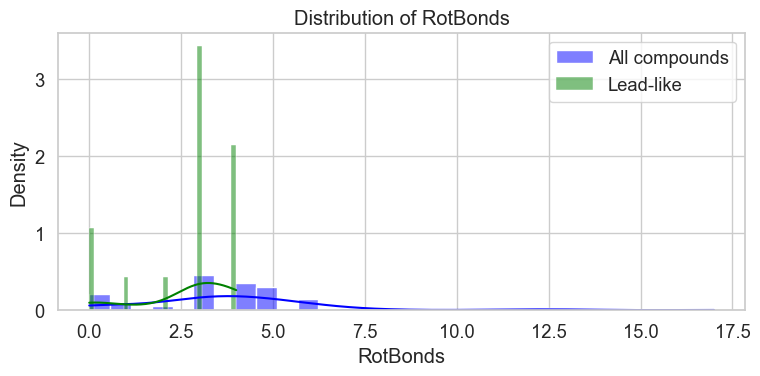

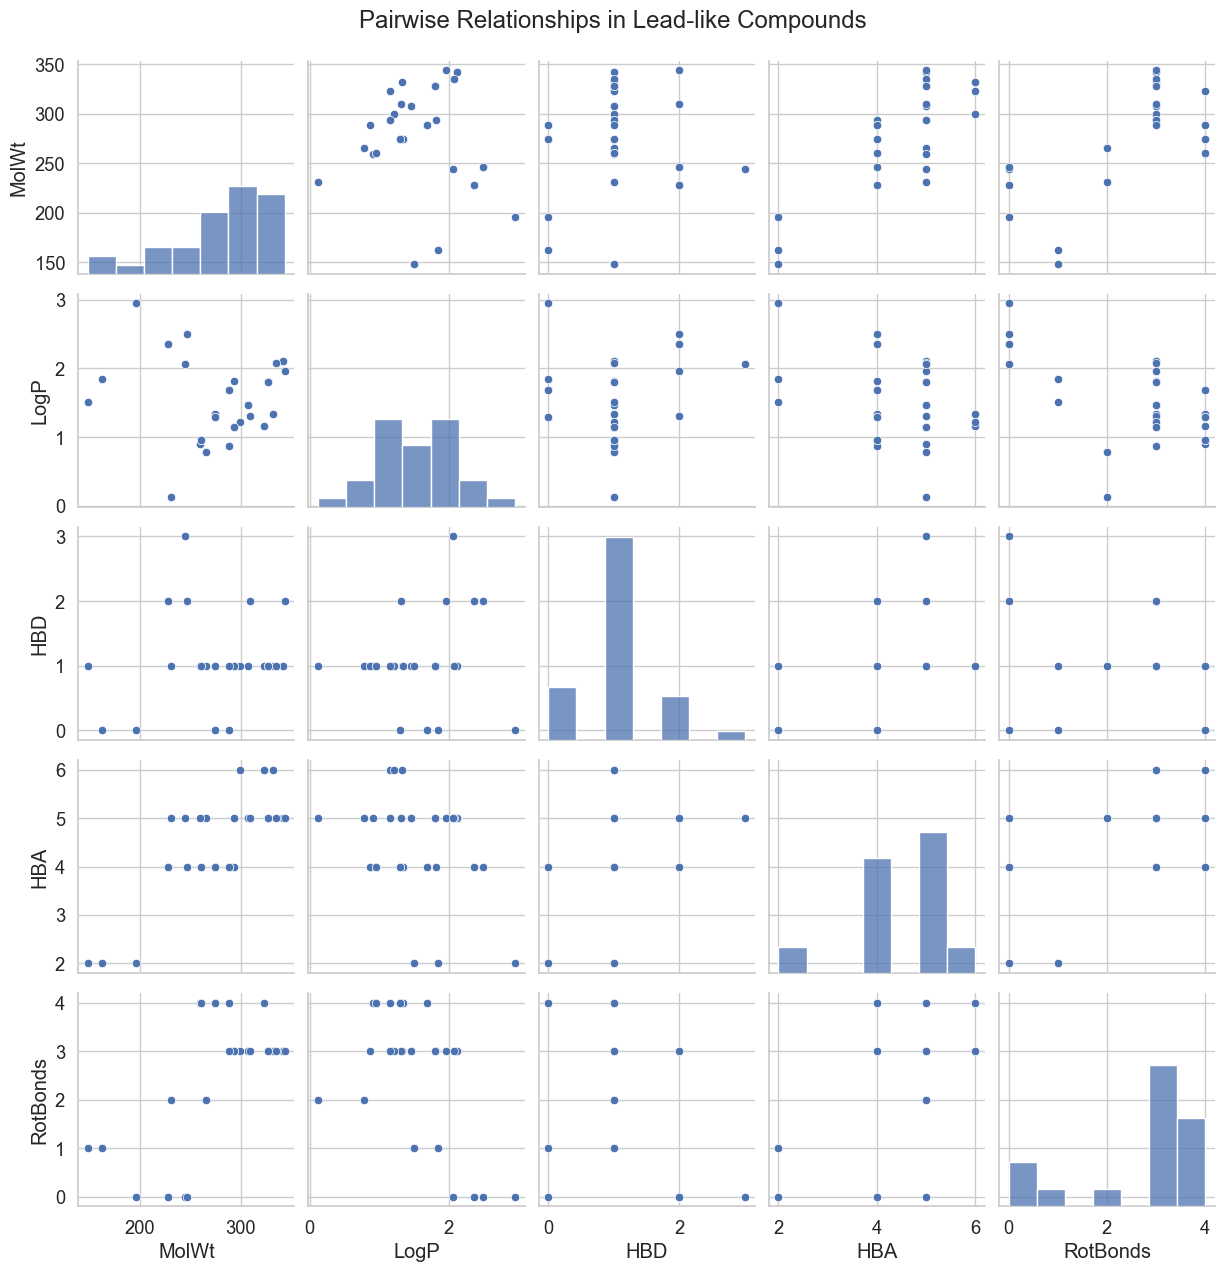

In [3]:
# 📊 T3_2: Visualizing Lead-like Compound Properties
# Author: Nghiên Cứu Thuốc | www.nghiencuuthuoc.com

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

# 📁 Step 1: Load data
base_path = '..'
path_all = os.path.join(base_path, 'data', 'T3_leadlike_extract.csv')
path_filtered = os.path.join(base_path, 'data', 'T3_leadlike_filtered.csv')

df_all = pd.read_csv(path_all)
df_filtered = pd.read_csv(path_filtered)

# 🧮 Step 2: Define descriptor calculation
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return {
            'MolWt': Descriptors.MolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'HBD': Lipinski.NumHDonors(mol),
            'HBA': Lipinski.NumHAcceptors(mol),
            'RotBonds': Descriptors.NumRotatableBonds(mol)
        }
    else:
        return {
            'MolWt': None,
            'LogP': None,
            'HBD': None,
            'HBA': None,
            'RotBonds': None
        }

# 🧪 Step 3: Compute descriptors if not present
if not set(['MolWt', 'LogP', 'HBD', 'HBA', 'RotBonds']).issubset(df_all.columns):
    desc_all = df_all['canonical_smiles'].apply(compute_descriptors).apply(pd.Series)
    df_all = pd.concat([df_all, desc_all], axis=1)

if not set(['MolWt', 'LogP', 'HBD', 'HBA', 'RotBonds']).issubset(df_filtered.columns):
    desc_filtered = df_filtered['canonical_smiles'].apply(compute_descriptors).apply(pd.Series)
    df_filtered = pd.concat([df_filtered, desc_filtered], axis=1)

# 💾 Optional: save with descriptors
df_all.to_csv(os.path.join(base_path, 'data', 'T3_leadlike_with_descriptors.csv'), index=False)
df_filtered.to_csv(os.path.join(base_path, 'data', 'T3_leadlike_filtered_descriptors.csv'), index=False)

# 🎨 Step 4: Visualization
sns.set(style='whitegrid', font_scale=1.2)
descriptors = ['MolWt', 'LogP', 'HBD', 'HBA', 'RotBonds']

for desc in descriptors:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_all[desc], color='blue', label='All compounds', kde=True, stat='density', bins=30)
    sns.histplot(df_filtered[desc], color='green', label='Lead-like', kde=True, stat='density', bins=30)
    plt.title(f'Distribution of {desc}')
    plt.xlabel(desc)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 🔁 Step 5 (Optional): Pairplot for filtered set
sns.pairplot(df_filtered[descriptors])
plt.suptitle("Pairwise Relationships in Lead-like Compounds", y=1.02)
plt.show()
